# ML Commando Course, 2018

Image Recognition with Support Vector Machines

_In this notebook, we show how to perform face recognition using Support Vector Machines. We will use the Olivetti faces dataset, included in Scikit-learn. More info at: http://scikit-learn.org/stable/datasets/olivetti_faces.html_

Start by importing numpy, scikit-learn, and pyplot, the Python libraries we will be using in this chapter. Show the versions we will be using (in case you have problems running the notebooks).

In [1]:
%pylab inline
import IPython
import sklearn as sk
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print ('IPython version:', IPython.__version__)
print ('numpy version:', np.__version__)
print ('scikit-learn version:', sk.__version__)
print ('matplotlib version:', matplotlib.__version__)

Populating the interactive namespace from numpy and matplotlib
IPython version: 6.2.1
numpy version: 1.13.3
scikit-learn version: 0.19.1
matplotlib version: 2.1.0


Import the olivetti faces dataset

In [2]:
from sklearn.datasets import fetch_olivetti_faces

# fetch the faces data
faces = fetch_olivetti_faces()

print (faces.DESCR)

Modified Olivetti faces dataset.

The original database was available from

    http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

The version retrieved here comes in MATLAB format from the personal
web page of Sam Roweis:

    http://www.cs.nyu.edu/~roweis/

There are ten different images of each of 40 distinct subjects. For some
subjects, the images were taken at different times, varying the lighting,
facial expressions (open / closed eyes, smiling / not smiling) and facial
details (glasses / no glasses). All the images were taken against a dark
homogeneous background with the subjects in an upright, frontal position (with
tolerance for some side movement).

The original dataset consisted of 92 x 112, while the Roweis version
consists of 64x64 images.



Let's look at the data, faces.images has 400 images of faces, each one is composed by a matrix of 64x64 pixels.
faces.data has the same data but in rows of 4096 attributes instead of matrices (4096 = 64x64)

In [3]:
print (faces.keys())
print (faces.images.shape)
print (faces.data.shape)
print (faces.target.shape)

np.set_printoptions(precision=2, threshold=np.nan) #rjm49 ... lets us print a face array out in full
print("What are we actually dealing with here?...")
print(faces.data[0])

dict_keys(['data', 'images', 'target', 'DESCR'])
(400, 64, 64)
(400, 4096)
(400,)
What are we actually dealing with here?...
[ 0.31  0.37  0.42  0.44  0.53  0.61  0.66  0.68  0.69  0.69  0.7   0.7
  0.69  0.7   0.69  0.69  0.69  0.7   0.7   0.7   0.7   0.71  0.71  0.72
  0.73  0.76  0.77  0.78  0.78  0.76  0.76  0.78  0.76  0.77  0.76  0.74
  0.74  0.74  0.74  0.72  0.72  0.71  0.72  0.72  0.72  0.73  0.74  0.71
  0.72  0.72  0.71  0.71  0.7   0.71  0.7   0.68  0.66  0.63  0.57  0.52
  0.45  0.37  0.33  0.31  0.34  0.4   0.44  0.47  0.55  0.62  0.67  0.69
  0.69  0.69  0.69  0.69  0.7   0.7   0.7   0.69  0.71  0.71  0.71  0.71
  0.71  0.7   0.72  0.73  0.74  0.76  0.78  0.79  0.78  0.78  0.77  0.79
  0.79  0.77  0.76  0.75  0.74  0.74  0.74  0.72  0.72  0.72  0.72  0.72
  0.72  0.72  0.73  0.72  0.73  0.72  0.72  0.72  0.71  0.7   0.7   0.67
  0.66  0.64  0.6   0.51  0.44  0.37  0.34  0.31  0.34  0.42  0.45  0.51
  0.57  0.64  0.68  0.69  0.69  0.69  0.7   0.69  0.7   0.71  0.71  0.7
 

We don't have to scale attributes, because data is already normalized

In [4]:
print (np.max(faces.data))
print (np.min(faces.data))
print (np.mean(faces.data))

1.0
0.0
0.547043


Plot the first 20 images. We have 40 individuals with 10 different images each.

In [5]:
def print_faces(images, target, min_n=0, top_n=20, faces_across=20):
    # set up the figure size in inches
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(min_n, top_n):
        # plot the images in a matrix of 20x20
        p = fig.add_subplot(faces_across, faces_across, i + 1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone)
        
        # label the image with the target value
        p.text(0, 14, str(target[i]), color='red') # this is the Person ID at the top
        p.text(0, 60, str(i), color='red') # this is the Imagine ID at the bottom
        
def faces_by_index(images, select):
    fig = plt.figure(figsize=(12,12))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i,s in enumerate(select):
        p = fig.add_subplot(5,5, i+1, xticks=[], yticks=[])
        p.imshow(images[s], cmap=plt.cm.bone)    

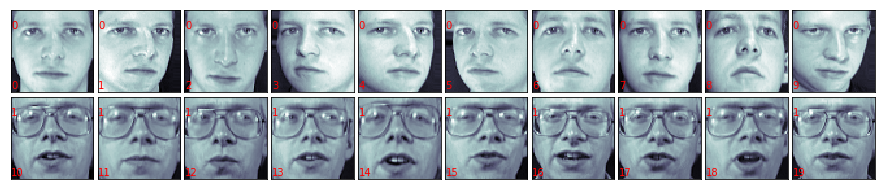

In [6]:
print_faces(faces.images, faces.target, top_n=20, faces_across=10)

Plot all the faces in a matrix of 20x20, for each one, we'll put it target value in the top left corner and it index in the bottom left corner.
It may take a few seconds.

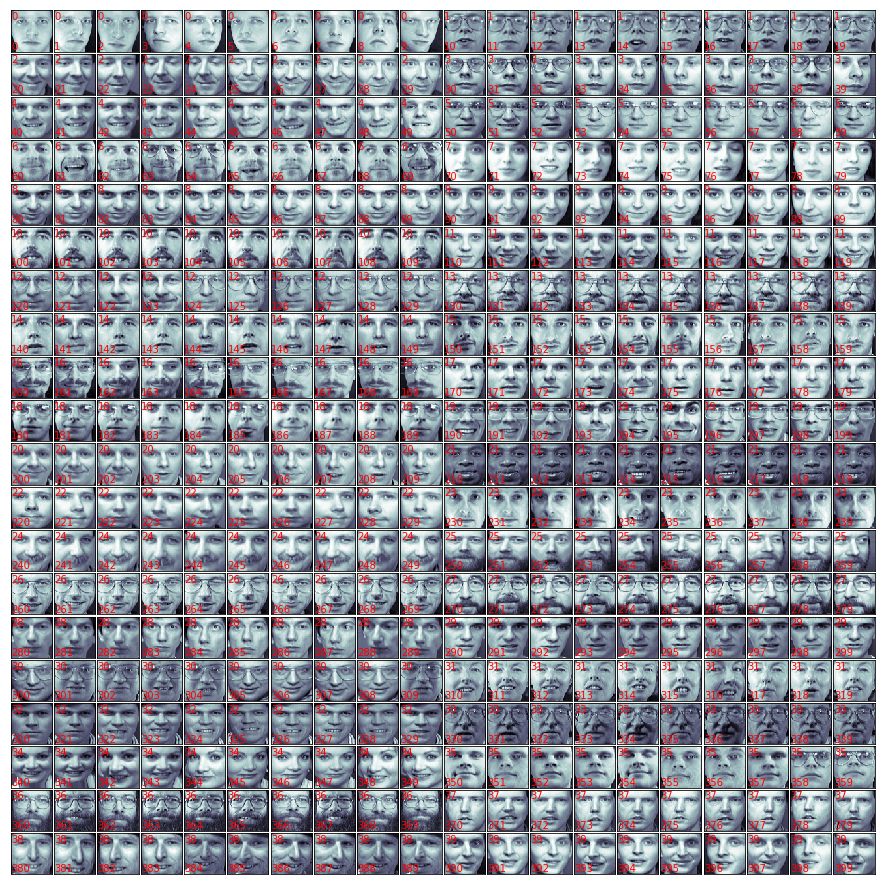

In [7]:
print_faces(faces.images, faces.target, top_n=400)

We will try to build a classifier whose model is a hyperplane that separates instances (points) of one class from the rest. Support Vector Machines (SVM) are supervised learning methods that try to obtain these hyperplanes in an optimal way, by selecting the ones that pass through the widest possible gaps between instances of different classes. New instances will be classified as belonging to a certain category based upon which side of the surfaces they fall. Let's import the SVC class from the sklearn.svm module. SVC stands for Support Vector Classifier: we will use SVM for classification.

Let's use a linear kernel: http://en.wikipedia.org/wiki/Kernel_%28linear_algebra%29

In [8]:
from sklearn.svm import SVC
svc_1 = SVC(kernel='linear')
print (svc_1)

from sklearn.linear_model import SGDClassifier
linclf = SGDClassifier(loss="hinge")
print(linclf)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


Build training and testing sets

In [9]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        faces.data, faces.target, test_size=0.25, random_state=0)

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Perform 5-fold cross-validation

In [10]:
from sklearn.cross_validation import cross_val_score, KFold
from scipy.stats import sem

def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold cross validation iterator
    cv = KFold(len(y), K, shuffle=True, random_state=0)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print (scores)
    print (("Mean score: {0:.3f} (+/-{1:.3f})").format(np.mean(scores), sem(scores)))

In [11]:
evaluate_cross_validation(svc_1, X_train, y_train, 5)

[ 0.93  0.87  0.92  0.93  0.92]
Mean score: 0.913 (+/-0.012)


In [12]:
from sklearn import metrics

def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    
    clf.fit(X_train, y_train)
    
    print ("Accuracy on training set:")
    print (clf.score(X_train, y_train))
    print ("Accuracy on testing set:")
    print (clf.score(X_test, y_test))
    
    y_pred = clf.predict(X_test)
    
    print ("Classification Report:")
    print (metrics.classification_report(y_test, y_pred))
    print ("Confusion Matrix:")
    print (metrics.confusion_matrix(y_test, y_pred))

Let's measure precision and recall on the evaluation set, for _each class_. 

In [13]:
train_and_evaluate(svc_1, X_train, X_test, y_train, y_test)

train_and_evaluate(linclf, X_train, X_test, y_train, y_test)

Accuracy on training set:
1.0
Accuracy on testing set:
0.99
Classification Report:
             precision    recall  f1-score   support

          0       0.86      1.00      0.92         6
          1       1.00      1.00      1.00         4
          2       1.00      1.00      1.00         2
          3       1.00      1.00      1.00         1
          4       1.00      1.00      1.00         1
          5       1.00      1.00      1.00         5
          6       1.00      1.00      1.00         4
          7       1.00      0.67      0.80         3
          9       1.00      1.00      1.00         1
         10       1.00      1.00      1.00         4
         11       1.00      1.00      1.00         1
         12       1.00      1.00      1.00         2
         13       1.00      1.00      1.00         3
         14       1.00      1.00      1.00         5
         15       1.00      1.00      1.00         3
         17       1.00      1.00      1.00         6
         19    

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Accuracy on training set:
0.0966666666667
Accuracy on testing set:
0.06
Classification Report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         6
          1       0.00      0.00      0.00         4
          2       0.00      0.00      0.00         2
          3       0.00      0.00      0.00         1
          4       0.00      0.00      0.00         1
          5       0.00      0.00      0.00         5
          6       0.00      0.00      0.00         4
          7       1.00      0.33      0.50         3
          9       0.00      0.00      0.00         1
         10       1.00      1.00      1.00         4
         11       0.00      0.00      0.00         1
         12       0.00      0.00      0.00         2
         13       0.00      0.00      0.00         3
         14       0.00      0.00      0.00         5
         15       0.00      0.00      0.00         3
         17       0.00      0.00      0.00         6
   

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Glasses or Not-Glasses?  The spectacle speculation spectacular.
Performace on face recognition is very good. Now, another problem: let's try to classify images of people with and without glasses. By hand, we have marked people with glasses. 

In [14]:
# the index ranges of images of people with glasses
glasses = [
	(10, 19), (30, 32), (37, 38), (50, 59), (63, 64),
	(69, 69), (120, 121), (124, 129), (130, 139), (160, 161),
	(164, 169), (180, 182), (185, 185), (189, 189), (190, 192),
	(194, 194), (196, 199), (260, 269), (270, 279), (300, 309),
	(330, 339), (358, 359), (360, 369)
]

Create training and test set for the new problem

In [15]:
def create_target(segments):
    # create a new y array of target size initialized with zeros
    y = np.zeros(faces.target.shape[0])
    # put 1 in the specified segments
    for (start, end) in segments:
        y[start:end + 1] = 1
    return y

In [16]:
target_glasses = create_target(glasses)

X_train, X_test, y_train, y_test = train_test_split(
        faces.data, target_glasses, test_size=0.25, random_state=0)

In [17]:
svc_2 = SVC(kernel='linear')
evaluate_cross_validation(svc_2, X_train, y_train, 5)
train_and_evaluate(svc_2, X_train, X_test, y_train, y_test)

[ 1.    0.95  0.98  0.98  0.93]
Mean score: 0.970 (+/-0.012)
Accuracy on training set:
1.0
Accuracy on testing set:
0.99
Classification Report:
             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99        67
        1.0       0.97      1.00      0.99        33

avg / total       0.99      0.99      0.99       100

Confusion Matrix:
[[66  1]
 [ 0 33]]


Almost perfect! Now, let's separate 10 completely different images (all from the same person, sometimes with glasses and sometimes without glasses). With this we'll try to discard that it's remembering faces, instead of features related with glasses.We'll separate the subject with indexes from 30 to 39. We'll train and evaluate in the rest of the 390 instances. After that, we'll evaluate again over the separated 10 instances.


10
y_train shape: 390
Accuracy on training set:
1.0
Accuracy on testing set:
0.9
Classification Report:
             precision    recall  f1-score   support

        0.0       0.83      1.00      0.91         5
        1.0       1.00      0.80      0.89         5

avg / total       0.92      0.90      0.90        10

Confusion Matrix:
[[5 0]
 [1 4]]


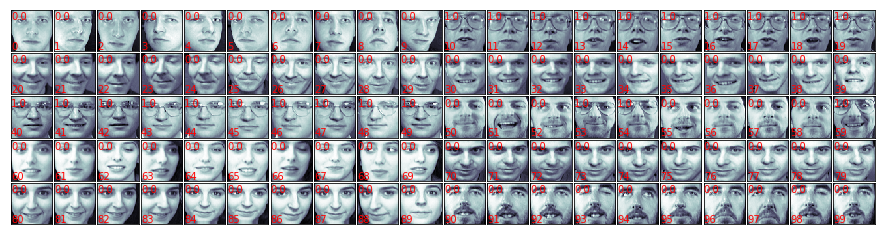

In [19]:
X_test = faces.data[30:40]
y_test = target_glasses[30:40]

print(y_test.shape[0])

select = np.ones(target_glasses.shape[0]) # <-- here we set an array all set to 1
select[30:40] = 0 #<-- here we convert any indices already assigned to testing 
X_train = faces.data[select == 1] #<-- we use the above array as a mask to get the same elements out of each of the following..
X_images = faces.images[select == 1]
y_train = target_glasses[select == 1]

#rjm49 - what have we got...
print_faces(X_images, y_train, top_n=100)
print("y_train shape:", y_train.shape[0])

#rjm49 - train up and run linear SVM classifier
svc_3 = SVC(kernel='linear')
train_and_evaluate(svc_3, X_train, X_test, y_train, y_test)
y_pred = svc_3.predict(X_test)

Show our evaluation faces, and their predicted category. Face number eight is incorrectly classified as no-glasses (probably because his eyes are closed!).

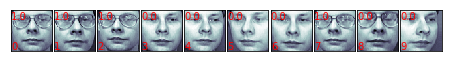

In [20]:
eval_faces = [np.reshape(a, (64, 64)) for a in X_test]
print_faces(eval_faces, y_pred, top_n=10)